In [ ]:
!pip install datasets

In [ ]:
!apt install git
!git lfs install

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Git LFS initialized.


In [ ]:
!git clone https://huggingface.co/datasets/CSALT/deepfake_detection_dataset_urdu

Cloning into 'deepfake_detection_dataset_urdu'...
remote: Enumerating objects: 6796, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6796 (delta 0), reused 0 (delta 0), pack-reused 6793 (from 1)
Receiving objects: 100% (6796/6796), 957.64 KiB | 12.12 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (6796/6796), done.
Filtering content: 100% (6794/6794), 1.82 GiB | 29.95 MiB/s, done.


In [ ]:
%cd deepfake_detection_dataset_urdu
%ls

[Errno 2] No such file or directory: 'deepfake_detection_dataset_urdu'
/content/deepfake_detection_dataset_urdu
Bonafide/  README.md  Spoofed_Tacotron/  Spoofed_TTS/


In [ ]:
from datasets import load_dataset
ds = load_dataset("CSALT/deepfake_detection_dataset_urdu", split="train")


FileNotFoundError: Couldn't find a dataset script at /content/deepfake_detection_dataset_urdu/deepfake_detection_dataset_urdu.py or any data file in the same directory.

In [ ]:
print(ds[0])

NameError: name 'ds' is not defined

In [ ]:
def infer_label(example):
    path = example["audio"]["path"]
    # bonafide directories → label 0
    if "Bonafide" in path:
        label = 0
    # any synthetic-TTS directories → label 1
    elif "Spoofed" in path or "VITS_TTS" in path:
        label = 1
    else:
        raise ValueError(f"Unknown category in {path}")
    return {"label": label}


In [ ]:
ds = ds.map(infer_label)

In [ ]:
print(ds.features)
print(ds[0])


{'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None), 'label': Value(dtype='int64', id=None)}
{'audio': {'path': None, 'array': array([ 0.00000000e+00,  0.00000000e+00, -3.05175781e-05, ...,
        7.32421875e-04,  1.22070312e-03,  1.28173828e-03]), 'sampling_rate': 16000}, 'label': 0}


## Feature Extraction

In [ ]:
import librosa
import numpy as np

def extract_mfcc(example,
                 sr=16000,
                 n_mfcc=13,
                 max_len=200):
    # grab raw samples
    y = example["audio"]["array"]

    # compute MFCCs (n_mfcc × T)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # pad or truncate time-frames to `max_len`
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)),
                      mode="constant")
    else:
        mfcc = mfcc[:, :max_len]

    # flatten into 1D vector
    return mfcc.flatten()


In [ ]:
# 1. Generate features
ds = ds.map(lambda ex: {"features": extract_mfcc(ex)},
            remove_columns=["audio"])

# 2. Convert to NumPy for sklearn/PyTorch
X = np.stack(ds["features"])
y = np.array(ds["label"])


In [ ]:
print(type(X), X.shape)
print(type(y), y.shape)


<class 'numpy.ndarray'> (6794, 2600)
<class 'numpy.ndarray'> (6794,)


In [ ]:
print("X[0][:5] =", X[0][:5])
print("y[0]     =", y[0])
print("y[6000]     =", y[6000])


X[0][:5] = [-631.28822666 -631.28822666 -631.28822666 -631.28822666 -631.28822666]
y[0]     = 0
y[6000]     = 1


## Fix Torch & Sympy Version

In [ ]:
import torch
print(torch.__version__) # must be 2.5.1



2.5.1+cu124


In [ ]:
# !pip uninstall torch -y
# !pip install torch==2.5.1


In [ ]:
import sympy
print(sympy.__version__) # 1.5.1

1.13.1


In [ ]:
# !pip uninstall sympy -y
# !pip install sympy==1.5.1


## Splitting the Data


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import sympy
# 1. Convert to tensors
X_tensor = torch.from_numpy(X).float()   # shape: (6794, 2600)
y_tensor = torch.from_numpy(y).long()    # shape: (6794,)

# 2. Build TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)

# 3. Split into train/test (if not already split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, stratify=y_tensor, random_state=42
)
train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test,  y_test)

# 4. Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)


## Logistic Regression

In [ ]:
import torch.nn as nn

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return torch.sigmoid(self.linear(x)).squeeze(1)


## Perceptron

In [ ]:
class PerceptronModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x).squeeze(1)


## Linear SVM

In [ ]:
class LinearSVM(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.linear(x).squeeze(1)


## DNN (2 Layer)

In [ ]:
class DNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64),         nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 1),           nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).squeeze(1)


## Improved DNN

In [ ]:
import torch.nn.functional as F

# -- Residual block with BatchNorm + Dropout --
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
        )
    def forward(self, x):
        return F.relu(self.net(x) + x)

# -- 1D-CNN front end to learn local time-freq patterns --
class CNNFrontEnd(nn.Module):
    def __init__(self, in_channels=13):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
        )
    def forward(self, x):
        # reshape flattened MFCCs (batch, 13*200) → (batch, 13, 200)
        b, fm = x.size()
        t = fm // 13
        x = x.view(b, 13, t)
        x = self.conv(x)
        return x.flatten(1)

# -- Channel-wise attention for frequency-band weighting --
class ChannelAttention(nn.Module):
    def __init__(self, dim, reduction=8):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc   = nn.Sequential(
            nn.Linear(dim, dim // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(dim // reduction, dim),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, f = x.size()
        y = self.pool(x.view(b, f, 1)).view(b, f)
        w = self.fc(y)
        return x * w

# -- Put it all together --
class ImprovedDNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # 1) convolutional front end on 13×200 MFCC
        self.front      = CNNFrontEnd(in_channels=13)
        # compute flattened dim after two 2× poolings: (200→100→50)×64 channels
        dim_after_cnn  = 64 * ( (200 // 2) // 2 )
        # 2) initial dense to project up to 128
        self.initial_fc = nn.Linear(dim_after_cnn, 128)
        # 3) stack two residual blocks at 128-dim
        self.res_blocks = nn.Sequential(
            ResidualBlock(128),
            ResidualBlock(128),
        )
        # 4) frequency-band attention
        self.attn       = ChannelAttention(128)
        # 5) final classifier head
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.front(x)
        x = F.relu(self.initial_fc(x))
        x = self.res_blocks(x)
        x = self.attn(x)
        return self.classifier(x).squeeze(1)


## Losses and Optimizers

In [ ]:
import torch.optim as optim

def hinge_loss(scores, labels, C=1.0):
    # labels: {0,1} → {-1,+1}
    y = labels.float() * 2 - 1
    return torch.clamp(1 - y * scores, min=0).mean() * C

# Instantiate models
input_dim = X.shape[1]
models = {
    'LogReg': LogisticRegressionModel(input_dim),
    'Perceptron': PerceptronModel(input_dim),
    'SVM': LinearSVM(input_dim),
    # 'DNN': DNN(input_dim),
    'DNN':       ImprovedDNN(input_dim)    # ← use the new class


}

# Choose criterion & optimizer per model
settings = {
    'LogReg': (
        torch.nn.BCELoss(),
        optim.Adam(
            models['LogReg'].parameters(),
            lr=1e-3,
            weight_decay=1e-4      # small L2 penalty
        )
    ),
    'Perceptron': (
        hinge_loss,
        optim.SGD(
            models['Perceptron'].parameters(),
            lr=1e-3,
            weight_decay=1e-4      # hinge + L2
        )
    ),
    'SVM': (
        hinge_loss,
        optim.SGD(
            models['SVM'].parameters(),
            lr=1e-3,
            weight_decay=1e-4      # same here
        )
    ),
    'DNN': (
        torch.nn.BCELoss(),
        optim.Adam(
            models['DNN'].parameters(),
            lr=1e-3,
            weight_decay=1e-4
        )
    )
}

## Training and Evaluations

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def train_epoch(model, criterion, optimizer, loader, device):
    model.train()
    batch_losses = []
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device).float()
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    return np.mean(batch_losses)   # <--- average per batch


def eval_model(model, loader, device='cpu'):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            out = model(Xb)
            prob = torch.sigmoid(out) if out.min()<0 or out.max()>1 else out
            ys.append(yb.cpu().numpy())
            ps.append(prob.cpu().numpy())
    y_true = np.concatenate(ys)
    y_prob = np.concatenate(ps)
    y_pred = (y_prob>0.5).astype(int)
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_prob)
    }

# Full train & eval
device = 'cuda' if torch.cuda.is_available() else 'cpu'
results = {}
for name, model in models.items():
    crit, opt = settings[name]
    model.to(device)
    # train for a few epochs
    for epoch in range(5):
        loss = train_epoch(model, crit, opt, train_loader, device)
    results[name] = eval_model(model, test_loader, device)

print(results)


{'LogReg': {'Accuracy': 0.8513612950699043, 'Precision': 0.9063032367972743, 'Recall': 0.7835051546391752, 'F1': 0.8404423380726699, 'AUC': np.float64(0.880861777700771)}, 'Perceptron': {'Accuracy': 0.8675496688741722, 'Precision': 0.8786039453717754, 'Recall': 0.8527245949926362, 'F1': 0.8654708520179372, 'AUC': np.float64(0.8704864419994802)}, 'SVM': {'Accuracy': 0.6526857983811626, 'Precision': 0.9859154929577465, 'Recall': 0.30927835051546393, 'F1': 0.47085201793721976, 'AUC': np.float64(0.6592426145716018)}, 'DNN': {'Accuracy': 0.9955849889624724, 'Precision': 0.9955817378497791, 'Recall': 0.9955817378497791, 'F1': 0.9955817378497791, 'AUC': np.float64(0.998979901238846)}}


## Printing the results

In [ ]:
import pandas as pd

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results).T  # Transpose to have models as rows

# Optionally, round the metrics for better readability
results_df = results_df.round(4)

# Display the table
print(results_df)


            Accuracy  Precision  Recall      F1     AUC
LogReg        0.8514     0.9063  0.7835  0.8404  0.8809
Perceptron    0.8675     0.8786  0.8527  0.8655  0.8705
SVM           0.6527     0.9859  0.3093  0.4709  0.6592
DNN           0.9956     0.9956  0.9956  0.9956  0.9990


## Visualize the results


Models sorted by AUC (best→worst):
            Accuracy  Precision  Recall      F1     AUC
DNN           0.9956     0.9956  0.9956  0.9956  0.9990
LogReg        0.8514     0.9063  0.7835  0.8404  0.8809
Perceptron    0.8675     0.8786  0.8527  0.8655  0.8705
SVM           0.6527     0.9859  0.3093  0.4709  0.6592

Models sorted by F1-Score (best→worst):
            Accuracy  Precision  Recall      F1     AUC
DNN           0.9956     0.9956  0.9956  0.9956  0.9990
Perceptron    0.8675     0.8786  0.8527  0.8655  0.8705
LogReg        0.8514     0.9063  0.7835  0.8404  0.8809
SVM           0.6527     0.9859  0.3093  0.4709  0.6592

🏆 Best model by AUC is DNN with AUC = 0.9990


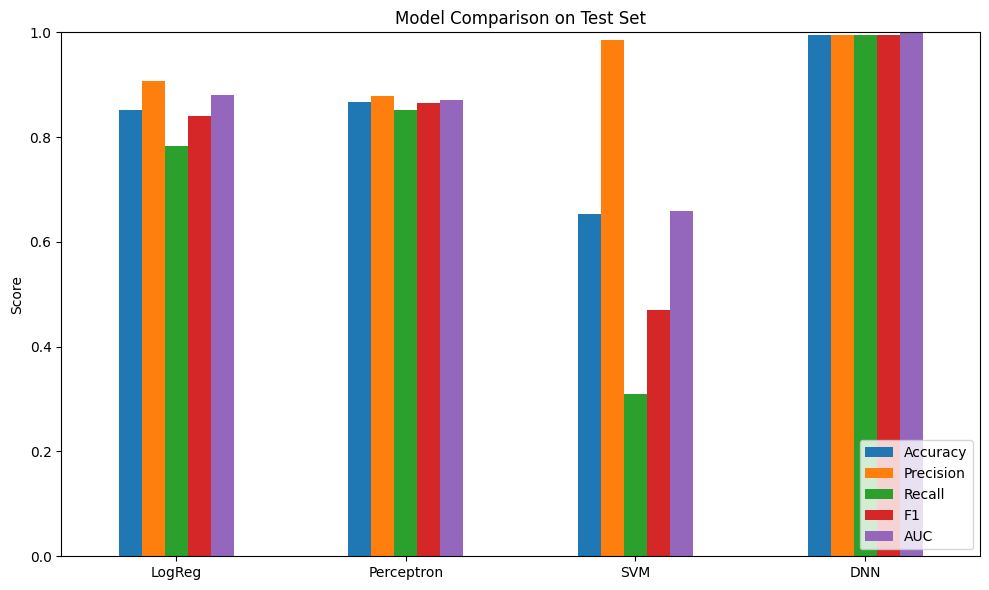

In [ ]:
# 1. Sort by AUC (highest first)
sorted_by_auc = results_df.sort_values(by="AUC", ascending=False)
print("\nModels sorted by AUC (best→worst):")
print(sorted_by_auc)

# 2. Or sort by any other metric, e.g. F1
sorted_by_f1 = results_df.sort_values(by="F1", ascending=False)
print("\nModels sorted by F1-Score (best→worst):")
print(sorted_by_f1)

# 3. Identify the single best model by your chosen metric
best_model_name = sorted_by_auc.index[0]
best_model_metrics = sorted_by_auc.iloc[0]
print(f"\n🏆 Best model by AUC is {best_model_name} with AUC = {best_model_metrics['AUC']:.4f}")

# 4. (Optional) Bar chart visualization
import matplotlib.pyplot as plt

# Plot all metrics for each model
results_df.plot(
    kind="bar",
    figsize=(10,6),
    ylim=(0,1),            # all metrics are between 0 and 1
    title="Model Comparison on Test Set"
)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


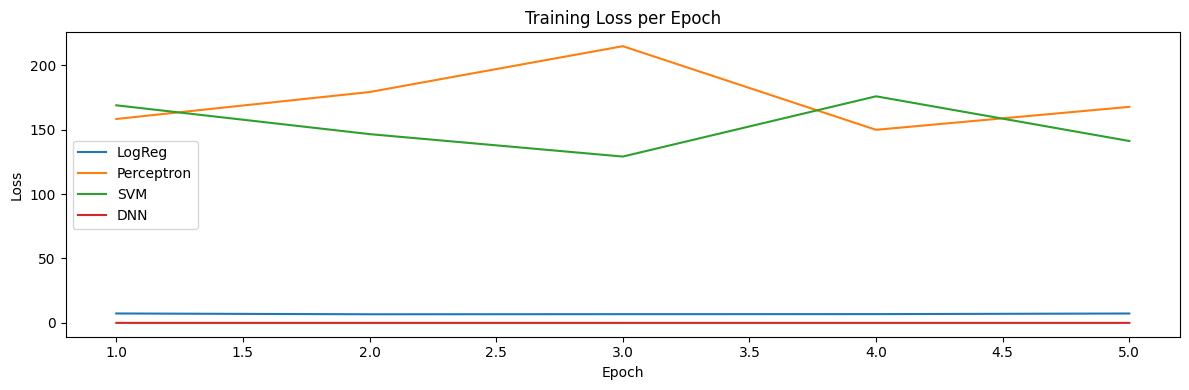

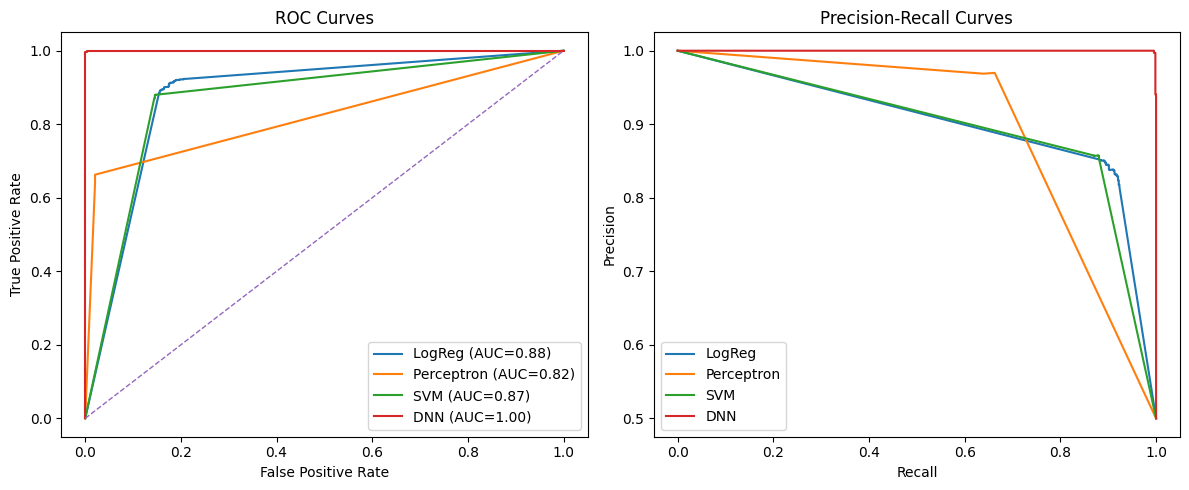

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Configuration
num_epochs = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1) Record training loss
loss_history = {name: [] for name in models}

for name, model in models.items():
    criterion, optimizer = settings[name]
    model.to(device)
    for epoch in range(1, num_epochs+1):
        loss = train_epoch(model, criterion, optimizer, train_loader, device)
        avg_loss = loss  # this is already per-sample avg
        loss_history[name].append(avg_loss)


# 2) Plot training-loss curves
plt.figure(figsize=(12, 4))
for name, losses in loss_history.items():
    plt.plot(range(1, num_epochs+1), losses, label=name)
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# 3) Compute test-set curves and plot ROC + Precision-Recall
plt.figure(figsize=(12, 5))

# ROC subplot
plt.subplot(1, 2, 1)
for name, model in models.items():
    model.to(device).eval()
    y_true, y_probs = [], []
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb = Xb.to(device)
            out = model(Xb)
            probs = torch.sigmoid(out) if (out.min()<0 or out.max()>1) else out
            y_true.extend(yb.numpy())
            y_probs.extend(probs.cpu().numpy())
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], '--', linewidth=1)
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')

# Precision-Recall subplot
plt.subplot(1, 2, 2)
for name, model in models.items():
    model.to(device).eval()
    y_true, y_probs = [], []
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb = Xb.to(device)
            out = model(Xb)
            probs = torch.sigmoid(out) if (out.min()<0 or out.max()>1) else out
            y_true.extend(yb.numpy())
            y_probs.extend(probs.cpu().numpy())
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    plt.plot(recall, precision, label=name)

plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


---

# Improved Version of That Process -> ✅

In [ ]:
!pip install datasets

from datasets import load_dataset
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc  # Added for ROC and PR curves
import matplotlib.pyplot as plt
import sympy
import joblib  # Added for saving non-DNN models
import pandas as pd  # Added for results display

# Verify versions
print(f"PyTorch version: {torch.__version__}")
!pip install upgrade torch==1.5.1
print(f"SymPy version: {sympy.__version__}")

PyTorch version: 2.6.0+cu124
ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade
SymPy version: 1.13.1


In [ ]:
# Load dataset
ds = load_dataset("CSALT/deepfake_detection_dataset_urdu", split="train")

# Infer labels based on file paths
def infer_label(example):
    path = example["audio"]["path"]
    if "Bonafide" in path:
        label = 0
    elif "Spoofed" in path or "VITS_TTS" in path:
        label = 1
    else:
        raise ValueError(f"Unknown category in {path}")
    return {"label": label}

ds = ds.map(infer_label)

# Feature extraction: MFCCs
def extract_mfcc(example, sr=16000, n_mfcc=13, max_len=200):
    y = example["audio"]["array"]
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode="constant")
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc.flatten()

# Generate features and remove audio column
ds = ds.map(lambda ex: {"features": extract_mfcc(ex)}, remove_columns=["audio"])

# Convert to NumPy arrays
X = np.stack(ds["features"])
y = np.array(ds["label"])

# Convert to tensors
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).long()

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, stratify=y_tensor, random_state=42
)
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

Repo card metadata block was not found. Setting CardData to empty.


ValueError: Invalid pattern: '**' can only be an entire path component

## Models

In [ ]:
# Model definitions
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return torch.sigmoid(self.linear(x)).squeeze(1)

class PerceptronModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.linear(x).squeeze(1)

class LinearSVM(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.linear(x).squeeze(1)

# Improved DNN with CNN frontend, residual blocks, and attention
class CNNFrontEnd(nn.Module):
    def __init__(self, in_channels=13):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32), nn.ReLU(inplace=True), nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64), nn.ReLU(inplace=True), nn.MaxPool1d(2),
        )
    def forward(self, x):
        b, fm = x.size()
        t = fm // 13
        x = x.view(b, 13, t)
        x = self.conv(x)
        return x.flatten(1)

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim), nn.BatchNorm1d(dim), nn.ReLU(inplace=True),
            nn.Dropout(0.3), nn.Linear(dim, dim), nn.BatchNorm1d(dim),
        )
    def forward(self, x):
        return F.relu(self.net(x) + x)

class ChannelAttention(nn.Module):
    def __init__(self, dim, reduction=8):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(dim, dim // reduction), nn.ReLU(inplace=True),
            nn.Linear(dim // reduction, dim), nn.Sigmoid()
        )
    def forward(self, x):
        b, f = x.size()
        y = self.pool(x.view(b, f, 1)).view(b, f)
        w = self.fc(y)
        return x * w

class ImprovedDNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.front = CNNFrontEnd(in_channels=13)
        dim_after_cnn = 64 * ((200 // 2) // 2)  # Adjust based on max_len and pooling
        self.initial_fc = nn.Linear(dim_after_cnn, 128)
        self.res_blocks = nn.Sequential(ResidualBlock(128), ResidualBlock(128))
        self.attn = ChannelAttention(128)
        self.classifier = nn.Sequential(
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(inplace=True),
            nn.Dropout(0.3), nn.Linear(64, 1), nn.Sigmoid()
        )
    def forward(self, x):
        x = self.front(x)
        x = F.relu(self.initial_fc(x))
        x = self.res_blocks(x)
        x = self.attn(x)
        return self.classifier(x).squeeze(1)

# Instantiate models
input_dim = X.shape[1]
models = {
    'LogReg': LogisticRegressionModel(input_dim),
    'Perceptron': PerceptronModel(input_dim),
    'SVM': LinearSVM(input_dim),
    'DNN': ImprovedDNN(input_dim)
}

## Loss Function and Optimizers

In [ ]:
# Loss functions and optimizers
def hinge_loss(scores, labels, C=1.0):
    y = labels.float() * 2 - 1  # Convert {0,1} to {-1,1}
    return torch.clamp(1 - y * scores, min=0).mean() * C

settings = {
    'LogReg': (nn.BCELoss(), optim.Adam(models['LogReg'].parameters(), lr=1e-3, weight_decay=1e-4)),
    'Perceptron': (hinge_loss, optim.SGD(models['Perceptron'].parameters(), lr=1e-3, weight_decay=1e-4)),
    'SVM': (hinge_loss, optim.SGD(models['SVM'].parameters(), lr=1e-3, weight_decay=1e-4)),
    'DNN': (nn.BCELoss(), optim.Adam(models['DNN'].parameters(), lr=1e-3, weight_decay=1e-4))
}

## Training and Evaluation

In [ ]:
# Training function
def train_epoch(model, criterion, optimizer, loader, device):
    model.train()
    batch_losses = []
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device).float()
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb) if callable(criterion) else criterion(out, yb)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    return np.mean(batch_losses)

# Evaluation function
def eval_model(model, loader, device='cpu'):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            out = model(Xb)
            prob = torch.sigmoid(out) if out.min() < 0 or out.max() > 1 else out
            ys.append(yb.cpu().numpy())
            ps.append(prob.cpu().numpy())
    y_true = np.concatenate(ys)
    y_prob = np.concatenate(ps)
    y_pred = (y_prob > 0.5).astype(int)
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_prob)
    }

## Model Training Loop and Saving

In [ ]:
# Full train & eval
device = 'cuda' if torch.cuda.is_available() else 'cpu'
results = {}
loss_history = {name: [] for name in models}

for name, model in models.items():
    crit, opt = settings[name]
    model.to(device)
    for epoch in range(5):
        loss = train_epoch(model, crit, opt, train_loader, device)
        loss_history[name].append(loss)
        print(f"{name} - Epoch {epoch+1}/5 - Loss: {loss:.4f}")
    results[name] = eval_model(model, test_loader, device)

# Save models
for name, model in models.items():
    if name == "DNN":
        torch.save(model.state_dict(), f"{name.lower()}_model.pth")
    else:
        joblib.dump(model, f"{name.lower()}_model.pkl")

## Plotting and Results Display

In [ ]:
# Plot training loss curves
plt.figure(figsize=(10, 6))
for name, losses in loss_history.items():
    plt.plot(range(1, 6), losses, label=name, marker='o', linewidth=2)
plt.title("Training Loss per Epoch", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Average Loss", fontsize=12)
plt.legend(title="Models", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot ROC and Precision-Recall curves
plt.figure(figsize=(12, 5))

# ROC subplot
plt.subplot(1, 2, 1)
for name, model in models.items():
    model.to(device).eval()
    y_true, y_probs = [], []
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb = Xb.to(device)
            out = model(Xb)
            probs = torch.sigmoid(out) if (out.min() < 0 or out.max() > 1) else out
            y_true.extend(yb.numpy())
            y_probs.extend(probs.cpu().numpy())
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], '--', linewidth=1)
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')

# Precision-Recall subplot
plt.subplot(1, 2, 2)
for name, model in models.items():
    model.to(device).eval()
    y_true, y_probs = [], []
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb = Xb.to(device)
            out = model(Xb)
            probs = torch.sigmoid(out) if (out.min() < 0 or out.max() > 1) else out
            y_true.extend(yb.numpy())
            y_probs.extend(probs.cpu().numpy())
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    plt.plot(recall, precision, label=name)
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

# Print evaluation results
results_df = pd.DataFrame(results).T
print(results_df)